In [1]:
%load_ext cython
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=64'
import cbclib as cbc
import numpy as np
import pandas as pd
import pyximport
from importlib import reload
import sys
import hdf5plugin
import h5py
import pygmo
import matplotlib.animation as animation
from tqdm.auto import tqdm
from scipy import ndimage
from scipy.optimize import minimize, differential_evolution
from scipy.interpolate import interpn

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider
from pickle import load, dump

pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport._pyximport3.PyxImportMetaFinder at 0x2ab9b792e3d0>)

In [2]:
inp = np.random.rand(50, 50, 50)

out = cbc.src.fftn(inp, shape=(75, 75), num_threads=8)
out2 = np.fft.fftn(inp, s=(75, 75))

In [3]:
np.all(np.isclose(out, out2))

True

In [4]:
inp = np.random.rand(50, 50, 50)

out = cbc.src.ifftn(inp, shape=(75, 75), num_threads=8)
out2 = np.fft.ifftn(inp, s=(75, 75))

In [5]:
np.all(np.isclose(out, out2))

True

In [2]:
def generate_lines(Y: int, X: int, n_lines: int, length: float, width: float) -> np.ndarray:
    lengths = length * np.random.rand(n_lines)
    thetas = 2 * np.pi * np.random.rand(n_lines)
    x0, y0 = np.array([[X], [Y]]) * np.random.rand(2, n_lines)
    return np.stack((x0 - 0.5 * lengths * np.cos(thetas),
                      y0 - 0.5 * lengths * np.sin(thetas),
                      x0 + 0.5 * lengths * np.cos(thetas),
                      y0 + 0.5 * lengths * np.sin(thetas),
                      width * np.ones(n_lines)), axis=1)

In [3]:
lines = generate_lines(50, 50, 1, 30, 2)

In [4]:
%time out = cbc.src.draw_line_image(lines, (50, 50), kernel='triangular')
%time out2 = cbc.bin.draw_line_image((50, 50), lines, profile='linear')

CPU times: user 367 µs, sys: 19 µs, total: 386 µs
Wall time: 291 µs
CPU times: user 286 µs, sys: 0 ns, total: 286 µs
Wall time: 271 µs


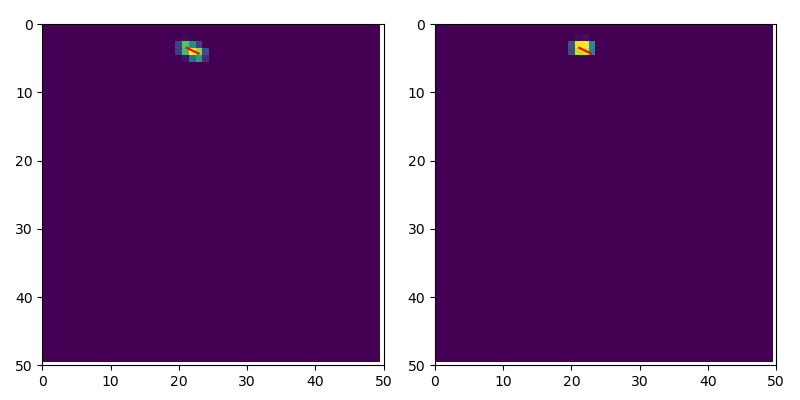

In [5]:
%matplotlib widget
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# ax.imshow(cbc.bin.draw_line_image((500, 500), lines))
axes[0].imshow(out)
axes[1].imshow(out2)

for line in lines:
    axes[0].plot(line[:4:2], line[1:4:2], c='r')
    axes[1].plot(line[:4:2], line[1:4:2], c='r')

for ax in axes:
    ax.set_xlim(0, 50)
    ax.set_ylim(50, 0)

fig.tight_layout()
plt.show()

In [6]:
frames = np.load('results/frames.npz')['data']
mask = np.ones(frames.shape, dtype=bool)

pts = (100, 100, 102, 102)

structure = cbc.src.Structure(2, 2)
line2 = cbc.src.test_line(pts, frames[0], mask[0], structure)
print(line2)

[94.14390495940982, 98.70175180237152, 94.88103593353188, 104.85308483384154]


In [7]:
from scripts.cbsd_numpy import add_line, generate_line, Image, Structure

struct = Structure.new(2, 2)
image = Image.new(frames[0], struct)
line = generate_line(pts[0], pts[1], image, struct.idxs)
line = add_line(line, generate_line(pts[2], pts[3], image, struct.idxs)).update_bounds(image)
print(line.bounds)

LineBounds(x0=94.14390536223841, y0=98.70175205903284, x1=94.88103665990128, y1=104.85308511749105)


In [8]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'det_to_k', 'det_to_k_vjp', 'k_to_det', 'k_to_det_vjp', 'k_to_smp', 'k_to_smp_vjp', 'np', 'source_lines', 'source_lines_vjp']


In [10]:
cbc.src.test_tree(10, 10.0)

Points generated:
{83.2613, 67.9121} {97.5813, 53.9623} {28.7962, 28.9063} {6.16723, 36.5579} {48.173, 56.1647} {81.4011, 70.4511} {4.82036, 50.6655} {63.822, 59.5787} {65.2842, 67.7098} {12.6736, 88.4512} 
Points in the tree:
{28.7962, 28.9063} {6.16723, 36.5579} {4.82036, 50.6655} {12.6736, 88.4512} {48.173, 56.1647} {63.822, 59.5787} {97.5813, 53.9623} {65.2842, 67.7098} {81.4011, 70.4511} {83.2613, 67.9121} 
Inserting {47.8426, 90.6602}
{47.8426, 90.6602} inserted
inserted == end() after inserting twice
Tree:
		(28.7962, 28.9063) axis = 0
	(6.16723, 36.5579) axis = 1
		(4.82036, 50.6655) axis = 0
			(12.6736, 88.4512) axis = 1
				(47.8426, 90.6602) axis = 0
(48.173, 56.1647) axis = 0
		(63.822, 59.5787) axis = 0
			(97.5813, 53.9623) axis = 1
	(65.2842, 67.7098) axis = 1
		(81.4011, 70.4511) axis = 0
			(83.2613, 67.9121) axis = 1
low  : [4.82036, 28.9063]
high : [97.5813, 90.6602]
{47.8426, 90.6602} found
erase returned {48.173, 56.1647}
Tree:
		(28.7962, 28.9063) axis = 0
	(6.16

In [11]:
inp = np.random.randint(0, 100, 400).reshape((20, 20))
%time peaks = cbc.src.local_maxima(inp, axis=(0, 1), num_threads=1)

CPU times: user 511 µs, sys: 86 µs, total: 597 µs
Wall time: 492 µs


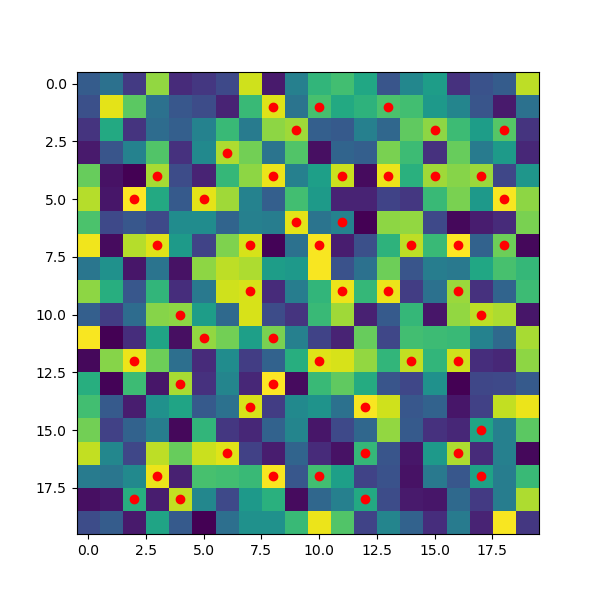

In [12]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(inp)
ax.scatter(peaks[:, 1], peaks[:, 0], c='r')
plt.show()

In [2]:
n_samples, ndim, sigma = 100, 1, 10.0
y = 10 * np.random.rand(n_samples)
x = 100 * np.random.rand(n_samples, ndim)
x_hat = np.sort(100 * np.random.rand(50, ndim), axis=0)

In [5]:
%time out = cbc.src.kr_predict(y, x, x_hat, 3 * sigma)
%time out2 = cbc.bin.kr_predict(y, x, x_hat, sigma)

CPU times: user 434 µs, sys: 158 µs, total: 592 µs
Wall time: 352 µs
CPU times: user 330 µs, sys: 0 ns, total: 330 µs
Wall time: 201 µs


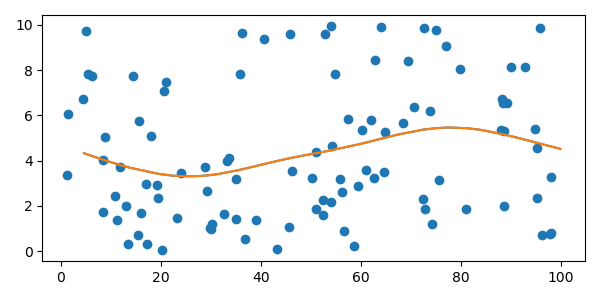

In [8]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x_hat, out)
ax.plot(x_hat, out2)
ax.scatter(x, y)

fig.tight_layout()
plt.show()

In [9]:
np.isclose(out, out2)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [10]:
shape = (10, 20, 30)
grid = tuple(np.arange(length) for length in np.array(shape)[::-1])
coords = np.random.rand(500, 3)
for i in range(len(shape)):
    coords[:, i] *= shape[len(shape) - 1 - i]
data = np.random.rand(*shape)

%time out = cbc.src.binterpolate(data, grid, coords)
%time out2 = cbc.bin.binterpolate(data, grid, coords)

CPU times: user 388 µs, sys: 0 ns, total: 388 µs
Wall time: 391 µs
CPU times: user 300 µs, sys: 77 µs, total: 377 µs
Wall time: 314 µs


In [11]:
np.all(np.isclose(out, out2, 1e-3, 1e-3))

True

In [12]:
gauss = cbc.src.gaussian_kernel(sigma=10.0, order=1)
gauss2 = cbc.bin.gaussian_kernel(sigma=10.0, order=1)

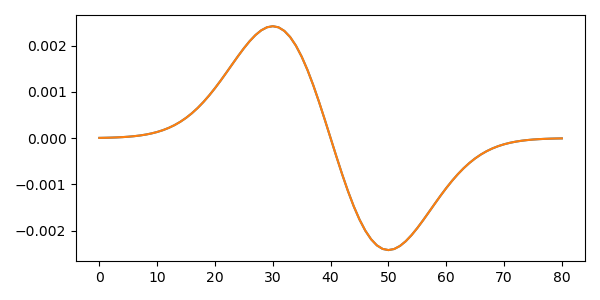

In [13]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(gauss)
ax.plot(gauss2)
fig.tight_layout()
plt.show()

In [6]:
lines = np.tile(np.array([0.0, 0.0, 1.5, 3.3, 1.0]), (100, 100, 1))
lines[..., [0, 2]] += np.random.randint(0, 500, (1, 100, 1))
lines[..., [1, 3]] += np.random.randint(0, 500, (1, 100, 1))
lines = list(lines)

In [7]:
%time out = cbc.src.draw_line_table(lines[0], (500, 500), kernel='parabolic', num_threads=1)
%time out2 = cbc.bin.draw_line_table(lines[0], (500, 500), profile='quad')

CPU times: user 567 µs, sys: 0 ns, total: 567 µs
Wall time: 482 µs
CPU times: user 431 µs, sys: 0 ns, total: 431 µs
Wall time: 349 µs


In [8]:
frame = np.zeros((500, 500))
np.add.at(frame, (out[1], out[0]), out[2])

In [55]:
frame = np.zeros((500, 500))
np.add.at(frame, (out2[2], out2[1]), out2[3])

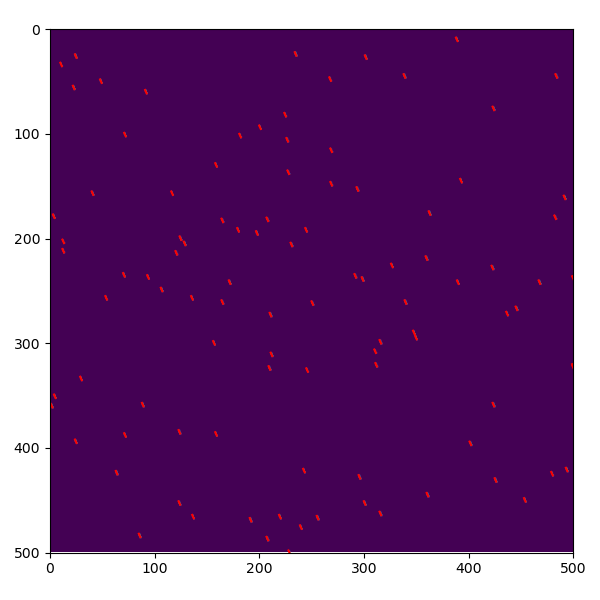

In [9]:
frame = frame

%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frame, vmin=0, vmax=1)
for line in lines[0]:
    ax.plot(line[:4:2], line[1:4:2], c='r')
ax.set_ylim(frame.shape[0], 0)
ax.set_xlim(0, frame.shape[1])
fig.tight_layout()
plt.show()

In [ ]:
from typing import Tuple

idxs = np.arange(-6, 6)
size = (0, 5)

def mirror(inp: np.ndarray, size: Tuple[int]):
    inp = inp - size[0]
    clip = size[1] - size[0] - 1
    quotient = (inp // clip) % 2
    return quotient * clip + (1 - 2 * quotient) * (inp % clip) + size[0]

def reflect(inp: np.ndarray, size: Tuple[int]):
    inp = inp - size[0]
    clip = size[1] - size[0]
    quotient = (inp // (clip)) % 2
    return quotient * (clip - 1) + (1 - 2 * quotient) * (inp % (clip)) + size[0]

def wrap(inp: np.ndarray, size: Tuple[int]):
    inp = inp - size[0]
    clip = size[1] - size[0]
    return (inp % clip) + size[0]

print(reflect(idxs, size))
print(mirror(idxs, size))
print(wrap(idxs, size))

In [ ]:
arr = np.random.rand(3, 3)

In [ ]:
from scipy.ndimage import median_filter

mode, size = 'wrap', (10, 10)
 
%time out = cbc.src.median_filter(arr, size=size, mode=mode)
%time out2 = cbc.bin.median_filter(arr, size=size, mode=mode)
%time out3 = median_filter(arr, size=size, mode=mode)

print(out == out3)

In [ ]:
arr = np.random.rand(100, 100, 100)

In [ ]:
axis = -1
 
%time out = cbc.src.median(arr, axis=axis)
%time out2 = cbc.bin.median(arr, axis=axis)
%time out3 = np.median(arr, axis=axis)

print(np.isclose(out, out2))

In [2]:
arr = np.ones((10, 10))
kernel = np.random.rand(5)

%time out = cbc.src.fft_convolve(arr, kernel, axis=-1)
%time out2 = cbc.bin.fft_convolve(arr, kernel, axis=-1)

np.isclose(out, out2)

CPU times: user 629 µs, sys: 273 µs, total: 902 µs
Wall time: 619 µs
CPU times: user 371 µs, sys: 0 ns, total: 371 µs
Wall time: 282 µs


array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [ ]:
arr = np.random.rand(10, 20)

%time out = cbc.src.gaussian_filter(arr, sigma=1.0)
%time out2 = cbc.bin.gaussian_filter(arr, sigma=1.0)

np.isclose(out, out2)

In [ ]:
arr = np.random.randint(0, 100000, size=(100, 100))

%time out2 = np.array([cbc.bin.next_fast_len(target, backend='fftw') for target in arr.ravel()]).reshape(arr.shape)
%time out = cbc.src.next_fast_len(arr)

out == out2

In [ ]:
basis = np.array([[-0.00093604, -0.00893389, -0.00049815],
                  [0.00688718, -0.00039195, -0.00573877],
                  [0.01180108, -0.00199115,  0.01430421]])
kmin = np.array([0.00876745, 0.00437237, 0.99995201])
kmax = np.array([0.03538482, 0.03246592, 0.99884627])
hkl = np.array([[ -8,  18,   5],
                [ 24,   4,   1],
                [  6, -12,  -5],
                [ -4,  -2,  -1],
                [ 17,  15,   5],
                [-19,  -3,  -3],
                [  0,  -7,  -3],
                [ 24,  -6,  -3],
                [ 16,  20,   6],
                [ -1,   9,   3]])
hkl = np.tile(hkl, (10, 1))

%time kin = dev.source_lines(hkl=hkl, basis=basis.ravel(), kmin=kmin, kmax=kmax)[0]
%time kin2 = cbc.src.source_lines(hkl=hkl, basis=basis, kmin=kmin[:2], kmax=kmax[:2])[0]

np.isclose(np.sort(kin, axis=1), np.sort(kin2, axis=1))

In [ ]:
crop = cbc.Crop(roi=(1100, 3260, 1040, 3108))
setup = cbc.ScanSetup.import_ini('results/Lysozyme_June_2021/exp_geom_232_ref_2.ini')

scan_num = 232
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'
h5_dir = os.path.join(dir_path, f'scan_frames/Scan_{scan_num:d}')
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                   if path.endswith(('LambdaFar.nxs', '.h5'))])
data = cbc.CrystData(cbc.CXIStore(h5_files), transform=crop)

wf_data = cbc.CrystData(cbc.CXIStore(f'results/Lysozyme_June_2021/scan_250_whitefield.h5'),
                        transform=crop).load('whitefield')

In [ ]:
idxs = np.arange(0, 300, 5)

data = data.clear().load(idxs=idxs)

In [ ]:
x0, y0 = crop.forward_points(x=setup.pupil_roi[2], y=setup.pupil_roi[0])
x1, y1 = crop.forward_points(x=setup.pupil_roi[3], y=setup.pupil_roi[1])
pad = 40
roi = (int(y0) - pad, int(y1) + pad, int(x0) - pad, int(x1) + pad)

In [ ]:
frames = np.arange(data.shape[0])
%time wf = cbc.bin.robust_mean(inp=data.data[frames] * data.mask[frames], \
                               axis=0, r0=0.0, r1=0.5, n_iter=12, lm=9.0, \
                               num_threads=data.num_threads)
%time wf2 = cbc.src.robust_mean(inp=data.data[frames], mask=data.mask[frames], \
                                axis=0, r0=0.0, r1=0.5, n_iter=12, lm=9.0, \
                                num_threads=data.num_threads)

In [ ]:
W = wf
std = np.sqrt(wf)
y = np.where(std, data.data / std, 0.0)
W = np.where(std, W / std, 0.0)

%time x = cbc.bin.robust_lsq(W=W, y=y, axis=(1, 2), r0=0.0, r1=0.5, n_iter=12, lm=9.0, \
                             num_threads=data.num_threads)
%time x2 = cbc.src.robust_lsq(W=W, y=y, mask=data.mask, axis=(1, 2), \
                              r0=0.0, r1=0.5, n_iter=12, lm=9.0, \
                              num_threads=data.num_threads)

print(x)
print(x2)